# MIS 284N Text Analysis Assignment 1

*Siqi Chen, Joshua Larky, Jiayan Lu, Jinru Su, Korawat Tanwisuth*

In [1]:
import pandas as pd
import matplotlib
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from pandas import Series, DataFrame
from collections import Counter, defaultdict
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Part A

### A1

In [2]:
job = pd.read_csv('/Users/meganchen/Desktop/text/hw1/Train_rev1.csv', encoding = 'utf-8', usecols=['FullDescription','SalaryNormalized'])
job_sample = job.sample(n=10000,random_state=1)

In [3]:
job_sample['tokens'] = job_sample['FullDescription'].map(word_tokenize)
words = job_sample['tokens'].sum()

In [4]:
tag_counts = defaultdict(int)
for (word, tag) in nltk.pos_tag(words): 
    tag_counts[tag] += 1
sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:5]

[('NN', 450942),
 ('NNP', 342706),
 ('IN', 257161),
 ('JJ', 216089),
 ('DT', 198748)]

### A2

In [5]:
import scipy.stats as ss
top_100 = Counter(words).most_common(100)
c_rank = ss.rankdata([c for (w, c) in top_100])
rev = [100-r+1 for r in c_rank]

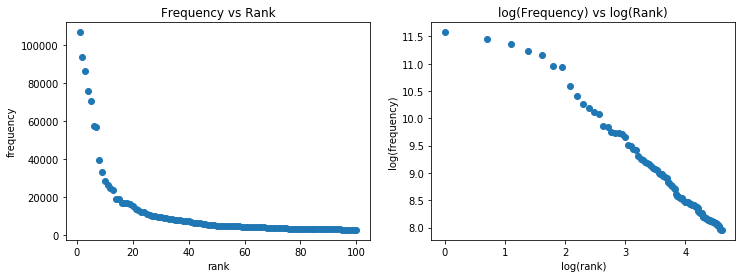

In [6]:
fig, (ax1, ax2) = subplots(nrows=1,
                           ncols=2,
                           figsize=(12, 4))
ax1.plot([c for c in rev], [c for (w, c) in top_100], 'o')
ax1.set_xlabel('rank')
ax1.set_ylabel('frequency')
ax1.set_title('Frequency vs Rank')

ax2.plot([np.log(c) for c in rev], [np.log(c) for (w, c) in top_100], 'o')
ax2.set_xlabel('log(rank)')
ax2.set_ylabel('log(frequency)')
ax2.set_title('log(Frequency) vs log(Rank)')

Plot on the left shows word frequency is inversely proportional to its rank, which satisfies Zipf's law. 

Plot on the right shows word frequency decreases at a lower rate for higher ranks. $k$ is approximately $\frac{11.5-11}{2} = 0.25$ for rank 1 to 7 ($ e^{2}$), and increase to approximately $\frac{11-8}{4.6-2} = 1.15$ for rank 7 to 100.

### A3

In [7]:
wnl = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
words_nonstop_lemma = [wnl.lemmatize(w) for w in words if w not in stopwords]
words_nonstop_lemma_dist = nltk.FreqDist(words_nonstop_lemma) 
rslt = pd.DataFrame(words_nonstop_lemma_dist.most_common(10),
                    columns=['Word', 'Frequency'])
rslt

,Word,Frequency
0,",",93494
1,.,86395
2,****,18828
3,:,17054
4,experience,13351
5,The,12477
6,role,11105
7,team,10893
8,work,10885
9,client,10199


## Part B

### B1

In [8]:
job_sample['target'] = 'low'
thresh_75 = job_sample['SalaryNormalized'].quantile(.75)
job_sample.loc[job_sample['SalaryNormalized'] >= thresh_75,'target'] = 'high'

In [9]:
job_data = job_sample['FullDescription'].str.lower().tolist()
job_label = job_sample['target'].tolist()

trainset_size = int(len(job_data)*0.7)

X_train = np.array([el for el in job_data[0:trainset_size]])
y_train = np.array([el for el in job_label[0:trainset_size]])

X_test = np.array([el for el in job_data[trainset_size:len(job_data)]]) 
y_test = np.array([el for el in job_label[trainset_size:len(job_label)]]) 

vectorizer = CountVectorizer()

In [10]:
X_train_all = vectorizer.fit_transform(X_train)
X_test_all = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train_all, y_train)
y_nb_predicted = nb_classifier.predict(X_test_all)

print ('\nHere is the accuracy score:')
print (metrics.accuracy_score(y_test, y_nb_predicted))

print ('\nHere is the confusion matrix:')
print (pd.crosstab(y_test,y_nb_predicted,rownames=['actual'], colnames=['predicted']))


Here is the accuracy score:
0.797333333333

Here is the confusion matrix:
predicted  high   low
actual               
high        548   211
low         397  1844


### B2

Lemmatization will reduce total number of words by grouping the inflected words as a single item and increase the prediction power of informative features. Hence we speculate that prediction accuracy will increase.

In [11]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = nltk.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]        

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())

In [12]:
X_train_lemma = vectorizer.fit_transform(X_train)
X_test_lemma = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train_lemma, y_train)
y_nb_predicted = nb_classifier.predict(X_test_lemma)

print ('\nHere is the accuracy score:')
print (metrics.accuracy_score(y_test, y_nb_predicted))

print ('\nHere is the confusion matrix:')
print (pd.crosstab(y_test,y_nb_predicted,rownames=['actual'], colnames=['predicted']))


Here is the accuracy score:
0.809666666667

Here is the confusion matrix:
predicted  high   low
actual               
high        528   231
low         340  1901


Prediction accuracy increases around 1.2% comparing to B1. Lemmatization helps prediction accuracy as we speculated.

### B3

Same as lemmatization, removing stopwords will reduce total number of words, increasing the relative frequency of informative features. Hence we speculate that prediction accuracy will increase as well.

In [13]:
vectorizer = CountVectorizer(stop_words='english')

In [14]:
X_train_nonstop = vectorizer.fit_transform(X_train)
X_test_nonstop = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train_nonstop, y_train)
y_nb_predicted = nb_classifier.predict(X_test_nonstop)

print ('\nHere is the accuracy score:')
print (metrics.accuracy_score(y_test, y_nb_predicted))

print ('\nHere is the confusion matrix:')
print (pd.crosstab(y_test,y_nb_predicted,rownames=['actual'], colnames=['predicted']))


Here is the accuracy score:
0.797666666667

Here is the confusion matrix:
predicted  high   low
actual               
high        562   197
low         410  1831


Prediction accuracy increases around 0.03% comparing to B1. The effect of removing stopwords on prediction accuracy is much smaller comparing to lemmatization.

In [15]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(nb_classifier.coef_[0], feature_names))
    top_low = [fn for (coef,fn) in coefs_with_fns[:n]]
    top_high = [fn for (coef,fn) in coefs_with_fns[:-(n + 1):-1]]
    print ('\n The top %d most informative features for low salary: \n %s'%(n,','.join(top_low))) 
    print ('\n The top %d most informative features for high salary: \n %s'%(n,','.join(top_high)))

In [16]:
show_most_informative_features(vectorizer, nb_classifier, n=10)


 The top 10 most informative features for low salary: 
 001,00ambition24hours,0131,015,0mq,0nt,100amps,1012,1015,10m

 The top 10 most informative features for high salary: 
 experience,work,role,team,skills,sales,working,business,client,company


### B4

In [17]:
def bi_words(x):
    tokens = word_tokenize(x.lower())
    pos = nltk.pos_tag(tokens)
    tag_list = []
    for p in pos:
        tag_list.append(p[1])
    bigrams = ngrams(tag_list,2)
    return ' '.join(tokens + [''.join(grams) for grams in bigrams])

In [18]:
job_sample['word_tag'] = job_sample['FullDescription'].apply(bi_words)

In [19]:
tag_data = job_sample['word_tag'].tolist()
tag_train = np.array([el for el in tag_data[0:trainset_size]])
tag_test = np.array([el for el in tag_data[trainset_size:len(tag_data)]])

In [20]:
vectorizer = CountVectorizer()
X_train_tag = vectorizer.fit_transform(tag_train)
X_test_tag = vectorizer.transform(tag_test)

In [21]:
nb_classifier = MultinomialNB().fit(X_train_tag, y_train)
y_nb_predicted = nb_classifier.predict(X_test_tag)

print ('\nHere is the accuracy score:')
print (metrics.accuracy_score(y_test, y_nb_predicted))

print ('\nHere is the confusion matrix:')
print (pd.crosstab(y_test,y_nb_predicted,rownames=['actual'], colnames=['predicted']))


Here is the accuracy score:
0.795666666667

Here is the confusion matrix:
predicted  high   low
actual               
high        540   219
low         394  1847


Prediction accuracy after adding POS bigrams to bag-of-words decreases slightly by 0.17% comparing to B1. 